# Comparison of Color Sampling Methods

This notebook compares three different approaches for generating well-distributed colors:

1. **Grid-based Sampling**: Using farthest point sampling on a grid
2. **Gradient Descent**: Using optimization to maximize minimum distances
3. **HSV Sampling**: Using evenly spaced colors in the HSV color space

We'll evaluate each method using various distance metrics to determine which produces the most well-distributed color palettes.

In [1]:
# import sys
# sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import time
import torch

from coloropt.grid import farthest_point_sampling_rgb, get_hsv_colors
from coloropt.gradient import optimize_points_3d
from coloropt.visualization import plot_color_list, convert_points_to_rgb
from coloropt.core import evaluate_point_distribution, compare_and_select_best_palette

## Experiment Setup

We'll generate color palettes of various sizes using each method and compare their quality using different metrics.

In [2]:
# Configuration parameters
n_colors_list = [8, 16]  # Number of colors to generate
prior_colors = None      # Optional prior colors to include

# Parameters for GD optimization
gd_params = {
    'alpha': 40.0,
    'lr': 0.01,
    'n_iters': 1500,
    'num_runs': 2
}

# Parameters for grid sampling
grid_params = {
    'sample_size': 100000  # Number of candidate points
}

# Parameters for HSV sampling
hsv_params = {
    'saturation': 0.85,
    'value': 0.85
}

## Generate Colors Using Different Methods

We'll now generate color palettes using each method and time their execution.

In [3]:
def generate_and_time_colors(n_colors, method='grid', params=None, prior_colors=None):
    """Generate colors using the specified method and time the execution."""
    start_time = time.time()
    
    if method == 'grid':
        # Grid-based sampling
        sample_size = params.get('sample_size', 100000)
        colors = farthest_point_sampling_rgb(n=n_colors, sample_size=sample_size, prior_colors=prior_colors)
        points_3d = np.array(colors) / 255.0  # Normalize to [0,1]
        
    elif method == 'gd':
        # Gradient descent optimization
        alpha = params.get('alpha', 40.0)
        lr = params.get('lr', 0.01)
        n_iters = params.get('n_iters', 1500)
        num_runs = params.get('num_runs', 2)
        
        # Handle prior colors for GD
        if prior_colors:
            prior_points = np.array(prior_colors) / 255.0  # Normalize to [0,1]
            n_free = n_colors - len(prior_colors)
            # Note: optimize_points_3d needs to be extended to support prior points
            # This is a placeholder for that functionality
            points_3d = optimize_points_3d(n_colors, alpha=alpha, lr=lr, n_iters=n_iters, num_runs=num_runs)
        else:
            points_3d = optimize_points_3d(n_colors, alpha=alpha, lr=lr, n_iters=n_iters, num_runs=num_runs)
        
        colors = convert_points_to_rgb(points_3d)
        
    elif method == 'hsv':
        # HSV color space sampling
        saturation = params.get('saturation', 0.85)
        value = params.get('value', 0.85)
        colors = get_hsv_colors(n=n_colors, saturation=saturation, value=value, 
        # prior_colors=prior_colors
        )
        points_3d = np.array(colors) / 255.0  # Normalize to [0,1]
    
    else:
        raise ValueError(f"Unknown method: {method}")
    
    elapsed_time = time.time() - start_time
    
    return colors, points_3d, elapsed_time

## Run Comparison Experiments

Now let's run experiments for each method and each palette size.

In [4]:
results = {}

for n_colors in n_colors_list:
    print(f"\n=== Generating {n_colors} colors ===\n")
    results[n_colors] = {}
    
    # Grid sampling
    print("Running grid sampling...")
    grid_colors, grid_points, grid_time = generate_and_time_colors(
        n_colors, method='grid', params=grid_params, prior_colors=prior_colors)
    grid_min_dist, grid_all_dists = evaluate_point_distribution(grid_points, f"Grid Sampling ({n_colors} colors)")
    results[n_colors]['grid'] = {
        'colors': grid_colors,
        'points': grid_points,
        'min_dist': grid_min_dist,
        'all_dists': grid_all_dists,
        'time': grid_time
    }
    
    # Gradient descent
    print("\nRunning gradient descent...")
    gd_colors, gd_points, gd_time = generate_and_time_colors(
        n_colors, method='gd', params=gd_params, prior_colors=prior_colors)
    gd_min_dist, gd_all_dists = evaluate_point_distribution(gd_points, f"Gradient Descent ({n_colors} colors)")
    results[n_colors]['gd'] = {
        'colors': gd_colors,
        'points': gd_points,
        'min_dist': gd_min_dist,
        'all_dists': gd_all_dists,
        'time': gd_time
    }
    
    # HSV sampling
    print("\nRunning HSV sampling...")
    hsv_colors, hsv_points, hsv_time = generate_and_time_colors(
        n_colors, method='hsv', params=hsv_params, prior_colors=prior_colors)
    hsv_min_dist, hsv_all_dists = evaluate_point_distribution(hsv_points, f"HSV Sampling ({n_colors} colors)")
    results[n_colors]['hsv'] = {
        'colors': hsv_colors,
        'points': hsv_points,
        'min_dist': hsv_min_dist,
        'all_dists': hsv_all_dists,
        'time': hsv_time
    }


=== Generating 8 colors ===

Running grid sampling...
--- Evaluation for Grid Sampling (8 colors) ---
Number of points: 8
Minimum distance: 0.6611
Mean distance: 1.0406
Median distance: 1.0067
Max distance: 1.5567


Running gradient descent...
--- Evaluation for Gradient Descent (8 colors) ---
Number of points: 8
Minimum distance: 0.6938
Mean distance: 1.0015
Median distance: 0.9392
Max distance: 1.4681


Running HSV sampling...
--- Evaluation for HSV Sampling (8 colors) ---
Number of points: 8
Minimum distance: 0.4034
Mean distance: 0.8047
Median distance: 0.8067
Max distance: 1.2498


=== Generating 16 colors ===

Running grid sampling...
--- Evaluation for Grid Sampling (16 colors) ---
Number of points: 16
Minimum distance: 0.4943
Mean distance: 0.9756
Median distance: 0.9864
Max distance: 1.7185


Running gradient descent...
--- Evaluation for Gradient Descent (16 colors) ---
Number of points: 16
Minimum distance: 0.5788
Mean distance: 1.0076
Median distance: 1.0805
Max distance: 

## Visualize Results

Let's visualize the color palettes generated by each method and compare their metrics.

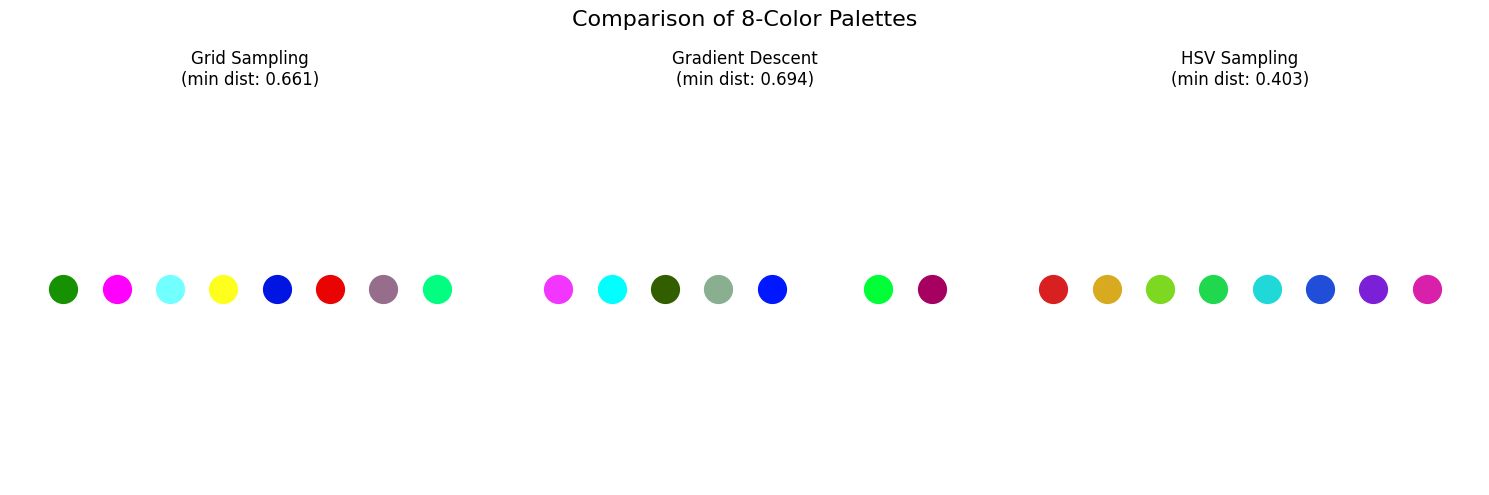

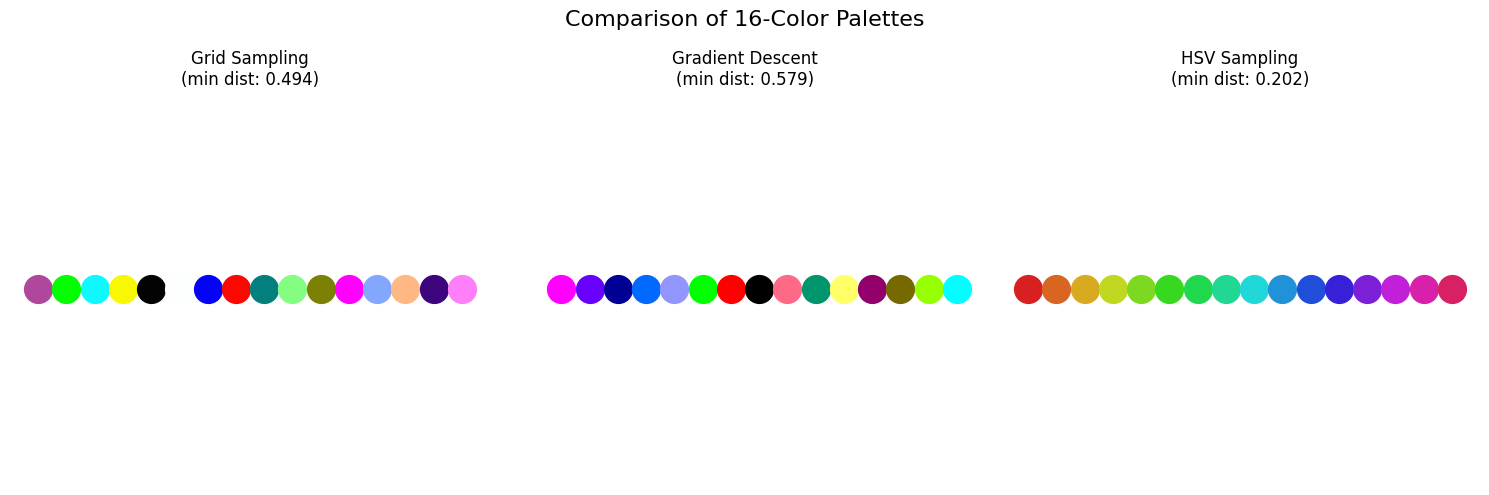

In [5]:
for n_colors in n_colors_list:
    plt.figure(figsize=(15, 5))
    
    # Plot grid sampling results
    plt.subplot(1, 3, 1)
    plot_color_list(results[n_colors]['grid']['colors'], 
                   title=f"Grid Sampling\n(min dist: {results[n_colors]['grid']['min_dist']:.3f})")
    
    # Plot GD results
    plt.subplot(1, 3, 2)
    plot_color_list(results[n_colors]['gd']['colors'], 
                   title=f"Gradient Descent\n(min dist: {results[n_colors]['gd']['min_dist']:.3f})")
    
    # Plot HSV results
    plt.subplot(1, 3, 3)
    plot_color_list(results[n_colors]['hsv']['colors'], 
                   title=f"HSV Sampling\n(min dist: {results[n_colors]['hsv']['min_dist']:.3f})")
    
    plt.suptitle(f"Comparison of {n_colors}-Color Palettes", fontsize=16)
    plt.tight_layout()
    plt.show()

In [6]:
# Compare metrics for each method
for n_colors in n_colors_list:
    print(f"\n=== Metrics for {n_colors} colors ===\n")
    
    print(f"{'Method':<15} {'Min Dist':<10} {'Mean Dist':<10} {'Median Dist':<12} {'Time (s)':<10}")
    print("-" * 60)
    
    for method in ['grid', 'gd', 'hsv']:
        res = results[n_colors][method]
        min_dist = res['min_dist']
        mean_dist = np.mean(res['all_dists'])
        median_dist = np.median(res['all_dists'])
        time_elapsed = res['time']
        
        print(f"{method:<15} {min_dist:<10.4f} {mean_dist:<10.4f} {median_dist:<12.4f} {time_elapsed:<10.4f}")


=== Metrics for 8 colors ===

Method          Min Dist   Mean Dist  Median Dist  Time (s)  
------------------------------------------------------------
grid            0.6611     1.0406     1.0067       1.6225    
gd              0.6938     1.0015     0.9392       6.0534    
hsv             0.4034     0.8047     0.8067       0.0000    

=== Metrics for 16 colors ===

Method          Min Dist   Mean Dist  Median Dist  Time (s)  
------------------------------------------------------------
grid            0.4943     0.9756     0.9864       7.0065    
gd              0.5788     1.0076     1.0805       1.0850    
hsv             0.2017     0.7551     0.7913       0.0000    


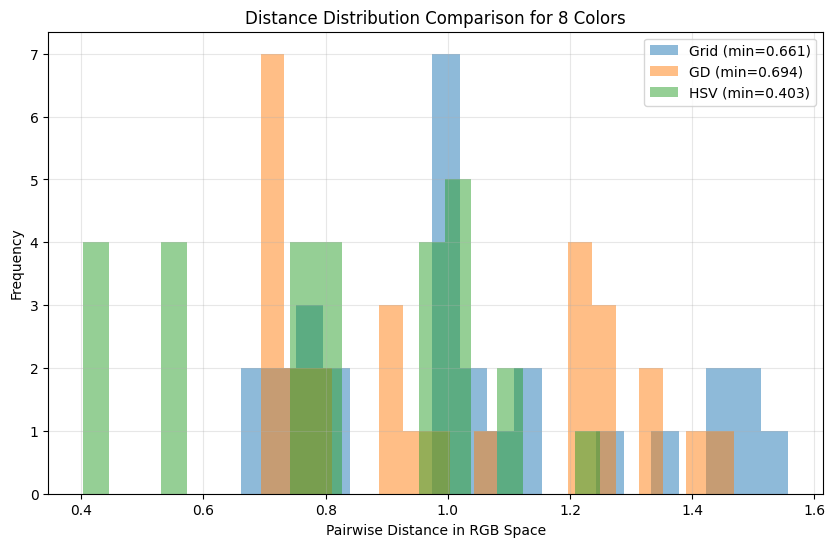

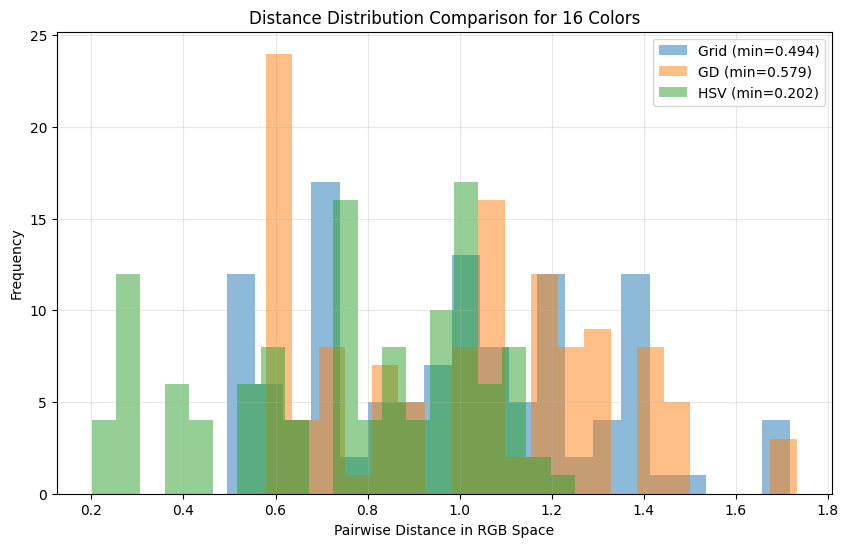

In [7]:
# Plot distance distributions
for n_colors in n_colors_list:
    plt.figure(figsize=(10, 6))
    
    plt.hist(results[n_colors]['grid']['all_dists'], bins=20, alpha=0.5, label=f'Grid (min={results[n_colors]["grid"]["min_dist"]:.3f})')
    plt.hist(results[n_colors]['gd']['all_dists'], bins=20, alpha=0.5, label=f'GD (min={results[n_colors]["gd"]["min_dist"]:.3f})')
    plt.hist(results[n_colors]['hsv']['all_dists'], bins=20, alpha=0.5, label=f'HSV (min={results[n_colors]["hsv"]["min_dist"]:.3f})')
    
    plt.xlabel('Pairwise Distance in RGB Space')
    plt.ylabel('Frequency')
    plt.title(f'Distance Distribution Comparison for {n_colors} Colors')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## Using the Best Palette Selector

Now let's use the `compare_and_select_best_palette` function to automatically select the best method.


=== Finding best palette for 8 colors ===

Comparing 3 methods for generating 8 colors
Running grid method...


  - grid: min_dist=0.6948, mean_dist=1.1593, time=1.56s
Running gd method...
  - gd: min_dist=0.7249, mean_dist=1.0229, time=1.04s
Running hsv method...
  - hsv: min_dist=0.4034, mean_dist=0.8047, time=0.00s

Best method: GD
  - min_dist: 0.7249
  - mean_dist: 1.0229
  - time: 1.04s


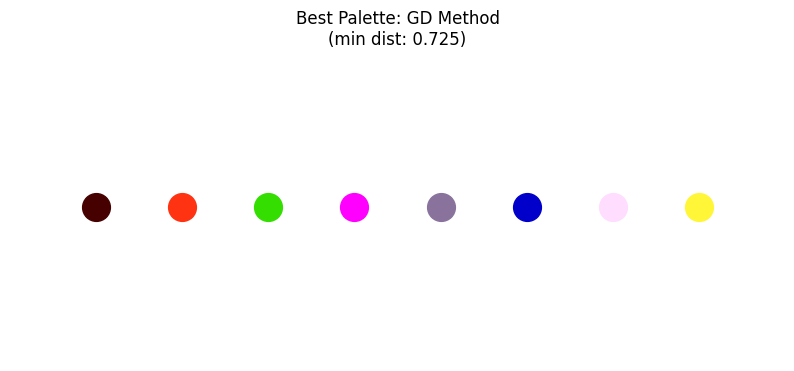


=== Finding best palette for 16 colors ===

Comparing 3 methods for generating 16 colors
Running grid method...
  - grid: min_dist=0.4964, mean_dist=0.9431, time=7.21s
Running gd method...
  - gd: min_dist=0.5803, mean_dist=0.9830, time=1.27s
Running hsv method...
  - hsv: min_dist=0.2017, mean_dist=0.7551, time=0.00s

Best method: GD
  - min_dist: 0.5803
  - mean_dist: 0.9830
  - time: 1.27s


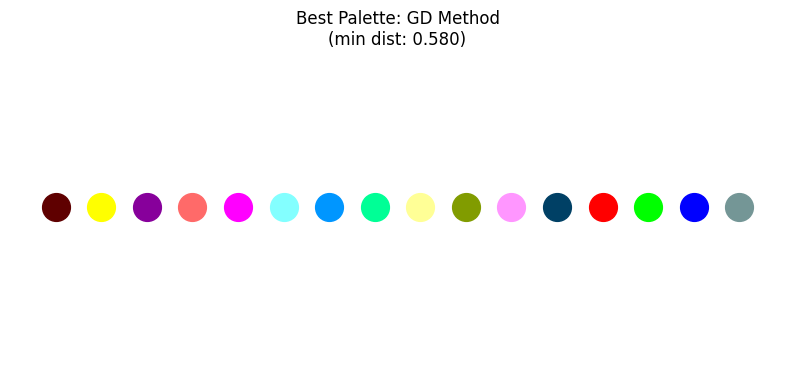

In [8]:
for n_colors in n_colors_list:
    print(f"\n=== Finding best palette for {n_colors} colors ===\n")
    
    # Collect parameters for each method
    params = {
        'grid': grid_params,
        'gd': gd_params,
        'hsv': hsv_params
    }
    
    # Call the best palette selector
    best_method, best_colors, metrics = compare_and_select_best_palette(
        n_colors=n_colors,
        prior_colors=prior_colors,
        method_params=params,
        criterion='min_dist',  # Use minimum distance as the selection criterion
        verbose=True
    )
    
    # Plot the best palette
    plt.figure(figsize=(10, 4))
    plot_color_list(best_colors, title=f"Best Palette: {best_method.upper()} Method\n(min dist: {metrics['min_dist']:.3f})")
    plt.show()

## Conclusion

Based on our experiments, we can draw several conclusions about the different color sampling methods:

1. **Minimum Distance**: The gradient descent approach typically produces palettes with the largest minimum distance between colors, making them more distinguishable.

2. **Computation Time**: HSV sampling is the fastest method.

3. **Distribution Shape**: Grid sampling and gradient descent tend to distribute colors more evenly across the RGB space, while HSV sampling focuses on spreading colors across the hue dimension.

4. **Best Method**: For applications where maximizing color distinguishability is critical and computation time is not a constraint, gradient descent is often the best choice.